In [110]:
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
import random as rd

In [111]:
with open('random_cnf.dimacs', 'r') as f:
    dimacs = f.read()
#print(dimacs)

In [112]:
oracle = PhaseOracle.from_dimacs_file('random_cnf.dimacs')
oracle.draw()

q_0: ─■─
      │ 
q_1: ─o─
      │ 
q_2: ─■─
      │ 
q_3: ─■─
      │ 
q_4: ─■─

In [113]:
class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a DIMACS file.
        Args:
            dimacs_file (str): path to the DIMACS file
    """
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        """Verifies a SAT solution against this object's
        DIMACS file.
            Args:
                guess (str): Assignment to be verified.
                             Must be string of 1s and 0s.
            Returns:
                bool: True if `guess` satisfies the
                           problem. False otherwise.
        """
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [114]:
# Function to create the
# random binary string
def rand_key(p):
   
    # Variable to store the
    # string
    key1 = ""
 
    # Loop to find the string
    # of desired length
    for i in range(p):
         
        # randint function to generate
        # 0, 1 randomly and converting
        # the result into str
        temp = str(rd.randint(0, 1))
 
        # Concatenation the random 0, 1
        # to the final result
        key1 += temp
         
    return(key1)

In [115]:
v = Verifier('random_cnf.dimacs')   

In [116]:
def generate_binary_strings(bit_count):
    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')


    genbin(bit_count)
    return binary_strings

binary_strings = generate_binary_strings(5)
print(binary_strings)

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [117]:
# Configure backend
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=2048)

# Create a new problem from the phase oracle and the
# verification function
problem = AmplificationProblem(oracle=oracle, is_good_state=v.is_correct)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
result.top_measurement

'11101'

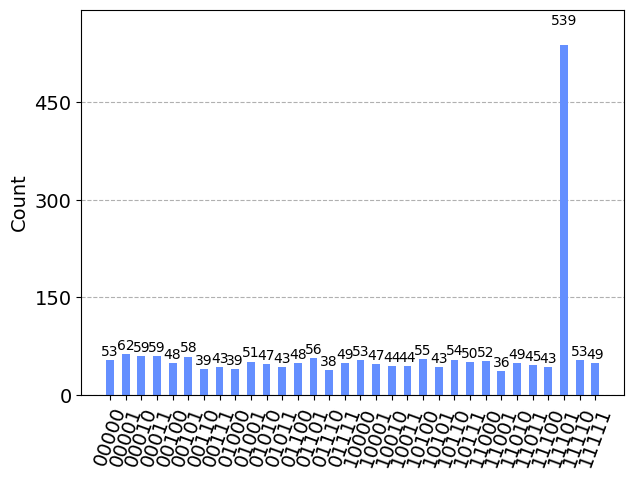

In [118]:
plot_histogram(result.circuit_results)